In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [2]:
using Plots, Statistics, DelimitedFiles

In [3]:
using CUDA
CUDA.device!(1)
CUDA.allowscalar(false)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


In [4]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm");

In [5]:
muext = 0.00
muint = 2.50;

# -------------- Choose family --------------

In [6]:
#fam = "PF00684"
#open("/home/louise/MSA/Data/test/PF00684/")
#L = 67; 

#J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

#delta = 50;
#al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
#M = length(al)

#Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
#lambda_o = Lambda_all[:,1];
#lambda_e = Lambda_all[:,2];


In [7]:
fam = "PF00397"
open("/home/louise/MSA/Data/test/PF00397/")
L = 31; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

delta = 5;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
M = length(al)

Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [8]:
##Random Data
#(N, L) = (6, 5) 
##(N, L) = (161, 67)

#lambda_o = ones(L)
#lambda_e = ones(L)
#H = rand(q,L)
#J = rand(q,q,L,L)
#J = J .+ permutedims(J, (2,1,4,3));

In [9]:
(Nmin, Nmax) = extrema([length(al[idx0][2]) for idx0 in 1:M])
ibig = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmax)[1]
ismall = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmin)[1];
(Nmin, Nmax, M)

(22, 52, 59696)

# -------------- one sequence, one epsilon --------------

In [10]:
data_seed = readdlm("results/data_comparewithseed/seedPF00397_index_name_alignment.txt");

In [15]:
@show size(data_seed, 1)
choose_seed = rand(1:size(data_seed, 1))

size(data_seed, 1) = 374


302

In [16]:
#idx0 = rand(1:M)
idx0 = data_seed[choose_seed,1]

52276

In [13]:
data_seed[choose_seed,:]

3-element Vector{Any}:
 55728
      ">C3Z2K2_BRAFL/165-194"
      "LPDNWEVAYTDN-NEMYFIDHNTGTTHWDDP"

In [14]:
al[idx0]

("C3Z2K2_BRAFL/160-199", "QDLGPLPDNWEVAYTDNNEMYFIDHNTGTTHWDDPRLQEG", "LPDNWEVAYTDN-NEMYFIDHNTGTTHWDDP", "LPDNWEVAYTDN-NEMYFIDHNTGTTHWDDP")

In [15]:
seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
@show seq
N = length(al[idx0][2])

seq = LPDNWEVAYTDN-NEMYFIDHNTGTTHWDDP
QDLGPLPDNWEVAYTDNNEMYFIDHNTGTTHWDDPRLQEG


40

In [16]:
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

ParamModel{Float32}[L=31 N=40 q=21 size=1.619 MiB]

In [17]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false

ϵ = -0.0
xnsol = fill((0, 0), L);
epscoupling=(false, T(ϵ), xnsol)
#epscoupling=(true, T(ϵ), xnsol_0)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [18]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=40 ongpu=true size=53.492 MiB]

In [19]:
##find ground state
iters = 700
minpol = 0.90
nmax = 30
minbet = 0.01
@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet);



beta = 0.0f0
converged: err=0.0009916648, tol=0.001, nbiter=57
(polar, energy, err) = (0.03843731f0, 43.098946f0, 0.0009916648f0)
beta = 0.1
converged: err=0.0009859502, tol=0.001, nbiter=40
(polar, energy, err) = (0.05081178f0, 35.459637f0, 0.0009859502f0)
beta = 0.2
converged: err=0.0009809732, tol=0.001, nbiter=45
(polar, energy, err) = (0.07124773f0, 26.275303f0, 0.0009809732f0)
beta = 0.30000000000000004
converged: err=0.000995174, tol=0.001, nbiter=114
(polar, energy, err) = (0.14766635f0, -31.994242f0, 0.000995174f0)
beta = 0.4
converged: err=0.0009999275, tol=0.001, nbiter=204
(polar, energy, err) = (0.815877f0, -58.040325f0, 0.0009999275f0)
beta = 0.5
converged: err=0.0009854436, tol=0.001, nbiter=184
(polar, energy, err) = (0.9413115f0, -58.040325f0, 0.0009854436f0)
204.233641 seconds (270.92 M allocations: 13.942 GiB, 4.17% gc time, 52.17% compilation time)


In [20]:
beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, exp(S_ϵ)

(0.5, 0.0009854436f0, 0.9413115f0, -58.040325f0, 0, -49.89576f0, 0.15659246137065272, 1.1695188926398448)

In [21]:
xnsol_vit, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
c = BpAlignGpu.check_sr!(xnsol_vit, L, N)
@show sum(c)
seqsol_vit = BpAlignGpu.convert_soltosequence!(xnsol_vit, seq.strseq, N, L)
energy_vit = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_vit[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)


sum(c) = 0


-58.040325f0

In [22]:
U_ϵ, energy_ϵ, energy_vit

(-49.89576f0, -58.040325f0, -58.040325f0)

In [23]:
seqsol_vit[1]

"LPDNWEVAYTDN-NEMYFIDHNTGTTHWDDP"

In [24]:
data_seed[choose_seed,3] == seqsol_vit[1]

true

In [25]:
#t_vit = zeros(size(bel_ϵ[:,:,:]))
#t_maxP = zeros(size(bel_ϵ[:,:,:]))
#for i=1:L
#    n,x = xnsol_vit[i]
#    t_vit[x+1, n+1, i] = 1.0
#    n,x = xnsol_ϵ[i]
#    t_maxP[x+1, n+1, i] = 1.0
#end

In [26]:
#p0 = heatmap(bel_ϵ[:,1,:], xlabel="i", ylabel="n", title="P_i:x=0")
#p1 = heatmap(bel_ϵ[:,2,:], xlabel="i", ylabel="n", title="P_i:x=1")
#p = plot(p0, p1, size=(800,400))

In [27]:
#p2 = heatmap(t_vit[:,1,:] .- t_maxP[:,1,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=0")
#p3 = heatmap(t_vit[:,2,:] .- t_maxP[:,2,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=1")
#plot(p2,p3, size=(800,400))

In [30]:
af.bpb.beliefs

42×2×31 CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}:
[:, :, 1] =
 0.0587496  0.0
 0.0        0.000852387
 0.0        0.00186312
 0.0        0.0495186
 0.0        0.0120303
 0.0        0.00901227
 0.0        0.864911
 0.0        0.00258091
 0.0        0.000403959
 0.0        2.86863f-5
 0.0        6.04847f-6
 0.0        8.43013f-6
 0.0        1.11738f-5
 ⋮          
 0.0        5.20011f-10
 0.0        2.75338f-10
 0.0        1.5412f-10
 0.0        9.07039f-11
 0.0        4.83156f-11
 0.0        2.75394f-11
 0.0        1.50207f-11
 0.0        9.65335f-12
 0.0        4.96455f-12
 0.0        2.52379f-12
 0.0        9.99017f-13
 0.0        0.0

[:, :, 2] =
 0.00855443   0.0
 3.7934f-5    0.000178149
 6.00386f-5   0.000430337
 0.000590328  0.000696366
 0.000183069  0.00733521
 0.000214518  0.0318923
 0.00491612   0.00610612
 0.00137786   0.933698
 0.000260362  0.00309427
 2.05021f-5   0.000290331
 1.41436f-6   1.31716f-5
 8.07273f-7   6.77147f-6
 1.11089f-6   8.66506f-6
 ⋮            
 8.3157

# Sampling with Viterbi

In [28]:
ntrials = 100*374

37400

In [29]:
diffE_Vsamps = []
xnsols_SAMP = []
seqsols_SAMP = []
for i in 1:ntrials
    xnsol_sampled = BpAlignGpu.viterbi_sampling(af, pm);
    seqsol_samp = BpAlignGpu.convert_soltosequence!(xnsol_sampled, seq.strseq, N, L)
    energy_samp = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_samp[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    diffE = energy_samp - energy_vit
    append!(diffE_Vsamps, diffE)
    append!(xnsols_SAMP, [xnsol_sampled])
    append!(seqsols_SAMP, [seqsol_samp[1]])
    #@show i, diffE
end

In [31]:
length(seqsols_SAMP |> unique)/ntrials

0.14074866310160428

In [32]:
include("results/functions_seq_based_metrics.jl")

count_mismatch (generic function with 1 method)

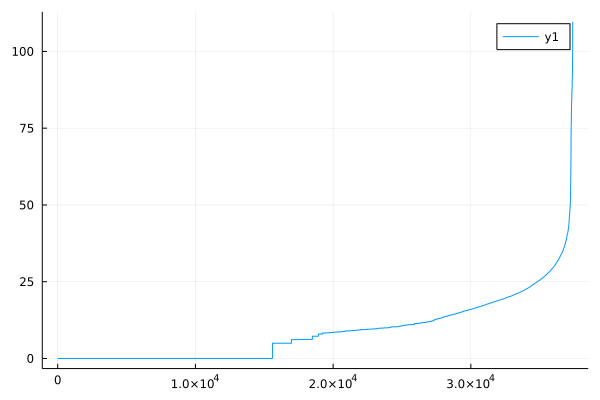

In [33]:
p1 = plot(sort(diffE_Vsamps,rev=false))

In [34]:
seqsol_ref_hmmer = al[idx0][3]
seqsol_ref = seqsol_vit[1]
hamming_distance(seqsol_ref_hmmer, seqsol_ref)

0

In [35]:
Hdist = []
for i in eachindex(seqsols_SAMP)
    dist = hamming_distance(seqsol_ref, seqsols_SAMP[i])
    append!(Hdist, dist)
end

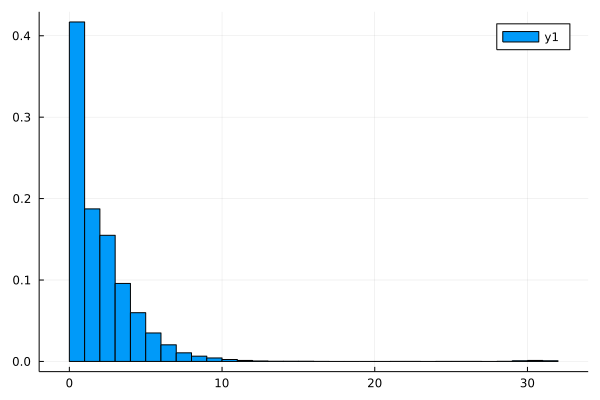

In [36]:
histogram(Hdist, bins = 50, normed = true)

In [37]:
Gp = []
Gm = []
for i in eachindex(seqsols_SAMP)
    np, nm = count_gap_pm(seqsol_ref, seqsols_SAMP[i])
    append!(Gp, np)
    append!(Gm, nm)
end

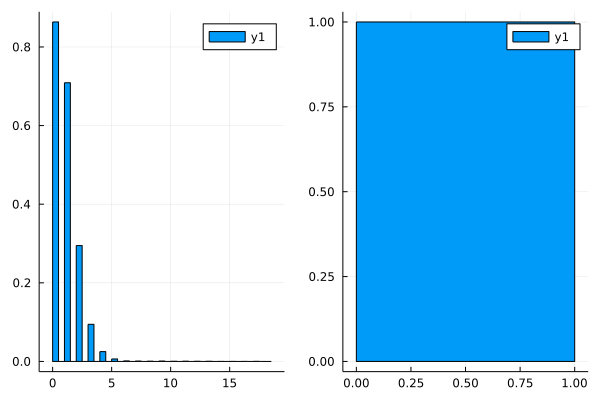

In [38]:
pp = histogram(Gp, bins = 50, normed = true)
pm = histogram(Gm, bins = 50, normed = true)
plot(pp, pm)

In [39]:
Mism = []
for i in eachindex(seqsols_SAMP)
    m = count_mismatch(seqsol_ref, seqsols_SAMP[i])
    append!(Mism, m)
end

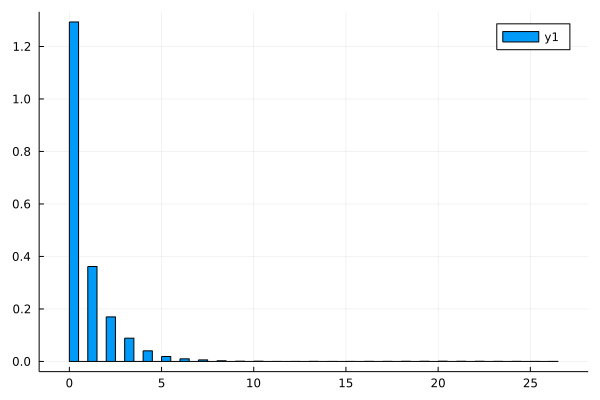

In [40]:
histogram(Mism, bins = 50, normed = true)

# Save Data

In [41]:
seqsols_SAMP[1]

"LPPGWAIKLSRTHKTEYYLNQTTNESSWVPP"

In [45]:
namefile = "sampling_oneseq_PF00397.fasta"

"sampling_oneseq_PF00397.fasta"

In [46]:
nameseq = data_seed[choose_seed,2]

">A3LXA7_PICST/8-38"

In [47]:
for i=1:ntrials
    open(namefile, "a") do io
        writedlm(io, [nameseq])
        writedlm(io, [seqsols_SAMP[i]])
    end
end

In [49]:
paramrun = [fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, minpol, nmax, minbet]
results = [beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ]
x0 = [x[1] for x in xnsol_vit]
x1 = [x[2] for x in xnsol_vit]
xc = vcat(x0, x1);

In [50]:
namefile = "Viterbi_sampling_"*string(idx0)*".txt"
open(namefile, "a") do io
    writedlm(io, [idx0 al[idx0][1]])
    writedlm(io, [paramrun])
    writedlm(io, [results])
    writedlm(io, [xc])
    writedlm(io, [diffE_Vsamps])
    writedlm(io, [Hdist])
    writedlm(io, [Gp])
    writedlm(io, [Gm])
    writedlm(io, [Mism])
end    

# Build MSA of sampled alignments

In [11]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false

ϵ = -0.0
xnsol = fill((0, 0), L);
epscoupling=(false, T(ϵ), xnsol)
#epscoupling=(true, T(ϵ), xnsol_0)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [12]:
iters = 700
minpol = 0.90
nmax = 30
minbet = 0.01


0.01

In [13]:
namefile_samp = "sampling_allseq_PF00397_initmaxP_keep75.fasta"
namefile_GS = "seed_SCE_PF00397.fasta"

"seed_SCE_PF00397.fasta"

In [14]:
ntrials = 134
nkeep = 100

100

In [ ]:
for (i,idx0) in pairs(Int64.(data_seed[:,1]))
    name_seq = data_seed[i,2]
    @show i,idx0,name_seq
    
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    @show seq
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    bpm = BPMessages(seq, pm, pa)
    bpb = BPBeliefs(N, L)
    lrf = LongRangeFields(N, L)
    af = AllFields(bpm, bpb, lrf)
    
    pa.beta = 0.0
    @time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet);
    
    xnsol_vit, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
    seqsol_vit = BpAlignGpu.convert_soltosequence!(xnsol_vit, seq.strseq, N, L)
    energy_vit = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_vit[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    c = BpAlignGpu.check_sr!(xnsol_vit, L, N)
    if sum(c) > 0
        println("problem during viterbi: new check=", sum(c))
        exit(0)
    end

    open(namefile_GS, "a") do io
        writedlm(io, [name_seq])
        writedlm(io, [seqsol_vit[1]])
    end

    MSA_samp = []
    diffE_Vsamps = []
    for i in 1:ntrials
        xnsol_sampled = BpAlignGpu.viterbi_sampling(af, pm, init=:maxP);
        seqsol_samp = BpAlignGpu.convert_soltosequence!(xnsol_sampled, seq.strseq, N, L)
        energy_samp = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_samp[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
        diffE = energy_samp - energy_vit
        append!(diffE_Vsamps, diffE)
        #open(namefile_samp, "a") do io
        #    writedlm(io, [name_seq])
        #    writedlm(io, [seqsol_samp[1]])
        #end
        append!(MSA_samp, [seqsol_samp[1]])
    end
    
    #keep only the ones with lowest diffE
    S = sort(diffE_Vsamps,rev=false)
    th = S[nkeep]
    MSA_cut = MSA_samp[diffE_Vsamps .<= th]
    @show nkeep, length(MSA_cut)
    for u in 1:nkeep
        open(namefile_samp, "a") do io
            writedlm(io, [name_seq])
            writedlm(io, [MSA_cut[u]])
        end
    end
        
    
    println("\n")
end

(i, idx0, name_seq) = (1, 58761, ">Q4GYL7_TRYB2/49-78")
seq = LPEHWKACRSEK-GELYYFNFKTGESIWDHP
GLKAPLPEHWKACRSEKGELYYFNFKTGESIWDHPLDEHF
beta = 0.0f0
converged: err=0.0009891018, tol=0.001, nbiter=57
(polar, energy, err) = (0.038517408f0, 41.676067f0, 0.0009891018f0)
beta = 0.1
converged: err=0.0009835511, tol=0.001, nbiter=40
(polar, energy, err) = (0.05082976f0, 47.010998f0, 0.0009835511f0)
beta = 0.2
converged: err=0.00096812844, tol=0.001, nbiter=45
(polar, energy, err) = (0.07124979f0, 24.737343f0, 0.00096812844f0)
beta = 0.30000000000000004
converged: err=0.0009963289, tol=0.001, nbiter=64
(polar, energy, err) = (0.11819649f0, -32.2864f0, 0.0009963289f0)
beta = 0.4
converged: err=0.0009942651, tol=0.001, nbiter=290
(polar, energy, err) = (0.7494118f0, -52.568497f0, 0.0009942651f0)
beta = 0.5
converged: err=0.0009763241, tol=0.001, nbiter=102
(polar, energy, err) = (0.90821713f0, -52.568497f0, 0.0009763241f0)
282.537847 seconds (270.36 M allocations: 13.915 GiB, 3.63% gc time, 57.33

converged: err=0.0009959191, tol=0.001, nbiter=55
(polar, energy, err) = (0.039868727f0, 35.818546f0, 0.0009959191f0)
beta = 0.1
converged: err=0.0009990036, tol=0.001, nbiter=41
(polar, energy, err) = (0.052402075f0, 42.897602f0, 0.0009990036f0)
beta = 0.2
converged: err=0.0009899139, tol=0.001, nbiter=45
(polar, energy, err) = (0.07322524f0, 15.858754f0, 0.0009899139f0)
beta = 0.30000000000000004
converged: err=0.0009873956, tol=0.001, nbiter=104
(polar, energy, err) = (0.15141964f0, -38.98871f0, 0.0009873956f0)
beta = 0.4
converged: err=0.0009966791, tol=0.001, nbiter=217
(polar, energy, err) = (0.85436785f0, -55.646954f0, 0.0009966791f0)
beta = 0.5
converged: err=0.0009822845, tol=0.001, nbiter=92
(polar, energy, err) = (0.9476523f0, -58.466206f0, 0.0009822845f0)
 82.889272 seconds (33.99 M allocations: 1.769 GiB, 2.27% gc time, 18.62% compilation time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (10, 939, ">A9UP18_MONBE/34-64")
seq = LPDGWHAVIEVQTNDVYFWNIHTDETQWK

converged: err=0.0009918883, tol=0.001, nbiter=63
(polar, energy, err) = (0.04128212f0, 31.17249f0, 0.0009918883f0)
beta = 0.1
converged: err=0.0009818971, tol=0.001, nbiter=42
(polar, energy, err) = (0.054042976f0, 36.98528f0, 0.0009818971f0)
beta = 0.2
converged: err=0.0009971261, tol=0.001, nbiter=46
(polar, energy, err) = (0.07567374f0, 11.601685f0, 0.0009971261f0)
beta = 0.30000000000000004
converged: err=0.0009997785, tol=0.001, nbiter=160
(polar, energy, err) = (0.191427f0, -39.661232f0, 0.0009997785f0)
beta = 0.4
converged: err=0.0009983927, tol=0.001, nbiter=190
(polar, energy, err) = (0.8577169f0, -60.557518f0, 0.0009983927f0)
beta = 0.5
converged: err=0.000983119, tol=0.001, nbiter=67
(polar, energy, err) = (0.93999594f0, -60.557518f0, 0.000983119f0)
 50.450135 seconds (31.61 M allocations: 1.615 GiB, 3.37% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (18, 13418, ">E5A099_LEPMJ/25-55")
seq = LPAGWTAQWDNSSRKYYYVQISTRVSQWELP
PTLPQLPAGWTAQWDNSSRKYYYVQI

converged: err=0.0009981096, tol=0.001, nbiter=54
(polar, energy, err) = (0.03726868f0, 47.69903f0, 0.0009981096f0)
beta = 0.1
converged: err=0.0009690672, tol=0.001, nbiter=40
(polar, energy, err) = (0.04960325f0, 39.028336f0, 0.0009690672f0)
beta = 0.2
converged: err=0.0009955466, tol=0.001, nbiter=44
(polar, energy, err) = (0.0701664f0, 5.4605184f0, 0.0009955466f0)
beta = 0.30000000000000004
converged: err=0.0009985268, tol=0.001, nbiter=170
(polar, energy, err) = (0.20175388f0, -44.42596f0, 0.0009985268f0)
beta = 0.4
converged: err=0.0009985566, tol=0.001, nbiter=214
(polar, energy, err) = (0.85480165f0, -59.545948f0, 0.0009985566f0)
beta = 0.5
converged: err=0.000995934, tol=0.001, nbiter=112
(polar, energy, err) = (0.9516243f0, -63.200466f0, 0.000995934f0)
 77.714519 seconds (35.14 M allocations: 1.798 GiB, 2.01% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (26, 24174, ">F6Z247_MOUSE/51-80")
seq = --DDWSEHISSS-GKKYYYNCRTEVSQWEKP
DAPYDSADDWSEHISSSGKKYYYNC

converged: err=0.0009898245, tol=0.001, nbiter=43
(polar, energy, err) = (0.06274444f0, 18.064758f0, 0.0009898245f0)
beta = 0.30000000000000004
converged: err=0.0009782314, tol=0.001, nbiter=45
(polar, energy, err) = (0.09735083f0, -38.210903f0, 0.0009782314f0)
beta = 0.4
converged: err=0.00099051, tol=0.001, nbiter=234
(polar, energy, err) = (0.8248494f0, -54.845253f0, 0.00099051f0)
beta = 0.5
converged: err=0.0009804666, tol=0.001, nbiter=87
(polar, energy, err) = (0.93280536f0, -57.16987f0, 0.0009804666f0)
 61.009026 seconds (26.25 M allocations: 1.338 GiB, 4.03% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (34, 51092, ">Q581S3_TRYB2/111-141")
seq = --EEWHEFFDSTTQHVFYCNSETGEVQWTPP
CEFDHKSEEWHEFFDSTTQHVFYCNSETGEVQWTPPTHKLD
beta = 0.0f0
converged: err=0.0009963289, tol=0.001, nbiter=53
(polar, energy, err) = (0.036986955f0, 53.107235f0, 0.0009963289f0)
beta = 0.1
converged: err=0.0009845495, tol=0.001, nbiter=39
(polar, energy, err) = (0.04913849f0, 36.457047

converged: err=0.000985682, tol=0.001, nbiter=169
(polar, energy, err) = (0.8149113f0, -63.061646f0, 0.000985682f0)
beta = 0.5
converged: err=0.0009810925, tol=0.001, nbiter=135
(polar, energy, err) = (0.94404614f0, -63.061646f0, 0.0009810925f0)
 67.416920 seconds (31.27 M allocations: 1.599 GiB, 2.33% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (42, 51603, ">B9PND3_TOXGV/145-175")
seq = -PSLWEVYFTPDSNIPYFYNALSKHVQWHRP
DLVGGPPSLWEVYFTPDSNIPYFYNALSKHVQWHRPLPPKE
beta = 0.0f0
converged: err=0.0009928495, tol=0.001, nbiter=57
(polar, energy, err) = (0.0378051f0, 31.03339f0, 0.0009928495f0)
beta = 0.1
converged: err=0.0009854138, tol=0.001, nbiter=39
(polar, energy, err) = (0.049988393f0, 60.04406f0, 0.0009854138f0)
beta = 0.2
converged: err=0.0009699762, tol=0.001, nbiter=45
(polar, energy, err) = (0.06999278f0, 38.955997f0, 0.0009699762f0)
beta = 0.30000000000000004
converged: err=0.0009873211, tol=0.001, nbiter=44
(polar, energy, err) = (0.10501489f0, -32.14751

converged: err=0.0009896755, tol=0.001, nbiter=249
(polar, energy, err) = (0.7042492f0, -46.63976f0, 0.0009896755f0)
beta = 0.5
converged: err=0.0009753108, tol=0.001, nbiter=99
(polar, energy, err) = (0.8905724f0, -51.013927f0, 0.0009753108f0)
beta = 0.6
converged: err=0.00096952915, tol=0.001, nbiter=61
(polar, energy, err) = (0.9452235f0, -51.013927f0, 0.00096952915f0)
 79.153333 seconds (33.99 M allocations: 1.740 GiB, 2.83% gc time, 4.71% compilation time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (50, 14051, ">B9PY18_TOXGV/16-45")
seq = LPPDWYEYHDPR-GVPYFHNPRLNVTQWERP
ASQAPLPPDWYEYHDPRGVPYFHNPRLNVTQWERPTASAS
beta = 0.0f0
converged: err=0.0009904876, tol=0.001, nbiter=60
(polar, energy, err) = (0.039053034f0, 51.850616f0, 0.0009904876f0)
beta = 0.1
converged: err=0.0009825081, tol=0.001, nbiter=41
(polar, energy, err) = (0.051501986f0, 50.90492f0, 0.0009825081f0)
beta = 0.2
converged: err=0.0009936392, tol=0.001, nbiter=44
(polar, energy, err) = (0.071958624f0,

converged: err=0.0009976029, tol=0.001, nbiter=45
(polar, energy, err) = (0.07176488f0, 15.803293f0, 0.0009976029f0)
beta = 0.30000000000000004
converged: err=0.0009927303, tol=0.001, nbiter=119
(polar, energy, err) = (0.16015166f0, -38.47039f0, 0.0009927303f0)
beta = 0.4
converged: err=0.0009855032, tol=0.001, nbiter=184
(polar, energy, err) = (0.8894957f0, -64.67527f0, 0.0009855032f0)
beta = 0.5
converged: err=0.0009845495, tol=0.001, nbiter=99
(polar, energy, err) = (0.96990216f0, -64.67527f0, 0.0009845495f0)
 50.375467 seconds (29.92 M allocations: 1.531 GiB, 2.08% gc time)
(nkeep, length(MSA_cut)) = (100, 101)


(i, idx0, name_seq) = (58, 41749, ">D0NCD8_PHYIT/86-115")
seq = LPPGWNEYRTPQ-GATYYYNSSTGVSTYDFP
STGPVLPPGWNEYRTPQGATYYYNSSTGVSTYDFPTQEQK
beta = 0.0f0
converged: err=0.0009882748, tol=0.001, nbiter=57
(polar, energy, err) = (0.038678665f0, 45.248245f0, 0.0009882748f0)
beta = 0.1
converged: err=0.0009823889, tol=0.001, nbiter=41
(polar, energy, err) = (0.05126968f0, 44.08085

converged: err=0.0009871721, tol=0.001, nbiter=46
(polar, energy, err) = (0.07457949f0, 2.2776055f0, 0.0009871721f0)
beta = 0.30000000000000004
converged: err=0.000991404, tol=0.001, nbiter=151
(polar, energy, err) = (0.17890953f0, -40.658478f0, 0.000991404f0)
beta = 0.4
converged: err=0.000998795, tol=0.001, nbiter=220
(polar, energy, err) = (0.880803f0, -61.330082f0, 0.000998795f0)
beta = 0.5
converged: err=0.0009824038, tol=0.001, nbiter=81
(polar, energy, err) = (0.96251726f0, -61.330082f0, 0.0009824038f0)
 68.508786 seconds (33.18 M allocations: 1.701 GiB, 2.21% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (66, 13193, ">Q8STT7_ENCCU/46-75")
seq = --DPWIECRSKR-GRVFYHNSITRESRWKRP
DEDFDVDPWIECRSKRGRVFYHNSITRESRWKRPPERKK
beta = 0.0f0
converged: err=0.0009939075, tol=0.001, nbiter=58
(polar, energy, err) = (0.03927704f0, 28.743263f0, 0.0009939075f0)
beta = 0.1
converged: err=0.0009877533, tol=0.001, nbiter=41
(polar, energy, err) = (0.052188244f0, 41.359943f0,

converged: err=0.00096932054, tol=0.001, nbiter=44
(polar, energy, err) = (0.07031175f0, 11.873209f0, 0.00096932054f0)
beta = 0.30000000000000004
converged: err=0.00097206235, tol=0.001, nbiter=41
(polar, energy, err) = (0.10635568f0, -24.092022f0, 0.00097206235f0)
beta = 0.4
converged: err=0.0009986758, tol=0.001, nbiter=229
(polar, energy, err) = (0.80861646f0, -58.392918f0, 0.0009986758f0)
beta = 0.5
converged: err=0.0009864569, tol=0.001, nbiter=67
(polar, energy, err) = (0.94091344f0, -58.392918f0, 0.0009864569f0)
 57.400872 seconds (26.51 M allocations: 1.353 GiB, 2.62% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (74, 47443, ">D2VRC5_NAEGR/303-333")
seq = LEEGWVAYYDYGSNQYYYHHAQSGTTTWDKP
QQEEQLEEGWVAYYDYGSNQYYYHHAQSGTTTWDKPVKKQA
beta = 0.0f0
converged: err=0.0009994581, tol=0.001, nbiter=54
(polar, energy, err) = (0.0372102f0, 41.695015f0, 0.0009994581f0)
beta = 0.1
converged: err=0.00097313523, tol=0.001, nbiter=40
(polar, energy, err) = (0.049472693f0,

converged: err=0.000993222, tol=0.001, nbiter=45
(polar, energy, err) = (0.07148569f0, 6.8344445f0, 0.000993222f0)
beta = 0.30000000000000004
converged: err=0.0009937584, tol=0.001, nbiter=106
(polar, energy, err) = (0.14817251f0, -40.05269f0, 0.0009937584f0)
beta = 0.4
converged: err=0.0009863973, tol=0.001, nbiter=173
(polar, energy, err) = (0.88537246f0, -61.595783f0, 0.0009863973f0)
beta = 0.5
converged: err=0.0009444952, tol=0.001, nbiter=86
(polar, energy, err) = (0.95764565f0, -63.18458f0, 0.0009444952f0)
 61.223352 seconds (28.10 M allocations: 1.436 GiB, 2.80% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (82, 10847, ">B3SD62_TRIAD/17-46")
seq = LPLGWKALTLEN-GRVYYVNYVTRKSQWYPP
RINRSLPLGWKALTLENGRVYYVNYVTRKSQWYPPPAQWR
beta = 0.0f0
converged: err=0.000991568, tol=0.001, nbiter=54
(polar, energy, err) = (0.037879173f0, 39.45912f0, 0.000991568f0)
beta = 0.1
converged: err=0.0009777695, tol=0.001, nbiter=40
(polar, energy, err) = (0.05048732f0, 38.160583f0,

converged: err=0.0009881854, tol=0.001, nbiter=44
(polar, energy, err) = (0.07028528f0, 11.104225f0, 0.0009881854f0)
beta = 0.30000000000000004
converged: err=0.000970453, tol=0.001, nbiter=44
(polar, energy, err) = (0.108297415f0, -32.63572f0, 0.000970453f0)
beta = 0.4
converged: err=0.000988841, tol=0.001, nbiter=268
(polar, energy, err) = (0.77901226f0, -54.2127f0, 0.000988841f0)
beta = 0.5
converged: err=0.0008659363, tol=0.001, nbiter=156
(polar, energy, err) = (0.9294973f0, -54.2127f0, 0.0008659363f0)
 76.163674 seconds (33.84 M allocations: 1.729 GiB, 2.93% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (90, 57639, ">Q4E4M0_TRYCC/381-410")
seq = ---EWKEARDKK-GRVYYYHPKEKKSCWN--
RVMLQRGEWKEARDKKGRVYYYHPKEKKSCWNLAKELQ
beta = 0.0f0
converged: err=0.00099089, tol=0.001, nbiter=62
(polar, energy, err) = (0.04126087f0, 34.213413f0, 0.00099089f0)
beta = 0.1
converged: err=0.0009860396, tol=0.001, nbiter=40
(polar, energy, err) = (0.053549822f0, 24.884819f0, 0.000

converged: err=0.0009972379, tol=0.001, nbiter=53
(polar, energy, err) = (0.03747775f0, 39.38178f0, 0.0009972379f0)
beta = 0.1
converged: err=0.000967443, tol=0.001, nbiter=42
(polar, energy, err) = (0.050281126f0, 29.462482f0, 0.000967443f0)
beta = 0.2
converged: err=0.0009793043, tol=0.001, nbiter=44
(polar, energy, err) = (0.070507325f0, 11.593311f0, 0.0009793043f0)
beta = 0.30000000000000004
converged: err=0.0009864569, tol=0.001, nbiter=110
(polar, energy, err) = (0.14736196f0, -38.00703f0, 0.0009864569f0)
beta = 0.4
converged: err=0.0009977818, tol=0.001, nbiter=218
(polar, energy, err) = (0.870798f0, -61.26089f0, 0.0009977818f0)
beta = 0.5
converged: err=0.0009975433, tol=0.001, nbiter=80
(polar, energy, err) = (0.96304f0, -61.26089f0, 0.0009975433f0)
 65.131081 seconds (30.30 M allocations: 1.551 GiB, 2.68% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (98, 57850, ">Q5AQA9_EMENI/55-85")
seq = -PYPWVPRWDERSQRYYYLNEQTGETTWEIP
PSAPQAPYPWVPRWDERSQRYYYLNEQTG

converged: err=0.0009679049, tol=0.001, nbiter=42
(polar, energy, err) = (0.0536283f0, 38.58143f0, 0.0009679049f0)
beta = 0.2
converged: err=0.00096938014, tol=0.001, nbiter=46
(polar, energy, err) = (0.07486948f0, 15.807669f0, 0.00096938014f0)
beta = 0.30000000000000004
converged: err=0.0009971559, tol=0.001, nbiter=226
(polar, energy, err) = (0.26305673f0, -45.081345f0, 0.0009971559f0)
beta = 0.4
converged: err=0.0009891689, tol=0.001, nbiter=206
(polar, energy, err) = (0.837175f0, -58.75608f0, 0.0009891689f0)
beta = 0.5
converged: err=0.0009884238, tol=0.001, nbiter=96
(polar, energy, err) = (0.94193494f0, -62.091835f0, 0.0009884238f0)
 54.384245 seconds (37.55 M allocations: 1.920 GiB, 2.62% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (106, 3139, ">C3Y503_BRAFL/545-575")
seq = -PRGWTCHWDRANRRYYYMNTATGESQWEYP
YELHAAPRGWTCHWDRANRRYYYMNTATGESQWEYPEDGVG
beta = 0.0f0
converged: err=0.0009933114, tol=0.001, nbiter=55
(polar, energy, err) = (0.0371618f0, 47.3597

converged: err=0.0009937733, tol=0.001, nbiter=152
(polar, energy, err) = (0.1793114f0, -43.246723f0, 0.0009937733f0)
beta = 0.4
converged: err=0.0009854436, tol=0.001, nbiter=172
(polar, energy, err) = (0.8862174f0, -61.854935f0, 0.0009854436f0)
beta = 0.5
converged: err=0.0009780526, tol=0.001, nbiter=79
(polar, energy, err) = (0.9503057f0, -63.652214f0, 0.0009780526f0)
 68.603170 seconds (30.40 M allocations: 1.555 GiB, 3.79% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (114, 13267, ">Q95PX8_CAEEL/155-184")
seq = ---AWNEFNAPD-GRKYYFNSITQENTWEKP
IPQNPDDAWNEFNAPDGRKYYFNSITQENTWEKPKALID
beta = 0.0f0
converged: err=0.0009928942, tol=0.001, nbiter=59
(polar, energy, err) = (0.039794218f0, 37.56237f0, 0.0009928942f0)
beta = 0.1
converged: err=0.00096546113, tol=0.001, nbiter=41
(polar, energy, err) = (0.052481305f0, 36.77105f0, 0.00096546113f0)
beta = 0.2
converged: err=0.00098598, tol=0.001, nbiter=46
(polar, energy, err) = (0.07356175f0, 17.843681f0, 0.00098598

converged: err=0.0009892285, tol=0.001, nbiter=43
(polar, energy, err) = (0.095419385f0, -24.659695f0, 0.0009892285f0)
beta = 0.4
converged: err=0.0009967089, tol=0.001, nbiter=253
(polar, energy, err) = (0.8524615f0, -59.9245f0, 0.0009967089f0)
beta = 0.5
converged: err=0.0009829402, tol=0.001, nbiter=90
(polar, energy, err) = (0.9484832f0, -59.9245f0, 0.0009829402f0)
 61.320846 seconds (27.21 M allocations: 1.391 GiB, 3.54% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (122, 19819, ">B3RPH2_TRIAD/254-283")
seq = LPPGWEMRHNPN-GRIYFIDHNTRRTQAI--
GNLGELPPGWEMRHNPNGRIYFIDHNTRRTQAIDPRIAIK
beta = 0.0f0
converged: err=0.0009937733, tol=0.001, nbiter=62
(polar, energy, err) = (0.039469197f0, 43.929005f0, 0.0009937733f0)
beta = 0.1
converged: err=0.0009878129, tol=0.001, nbiter=39
(polar, energy, err) = (0.0515513f0, 35.873848f0, 0.0009878129f0)
beta = 0.2
converged: err=0.0009678006, tol=0.001, nbiter=45
(polar, energy, err) = (0.07340303f0, 8.432314f0, 0.0009678006f

converged: err=0.0009678155, tol=0.001, nbiter=40
(polar, energy, err) = (0.05145125f0, 31.314365f0, 0.0009678155f0)
beta = 0.2
converged: err=0.0009907186, tol=0.001, nbiter=45
(polar, energy, err) = (0.07291091f0, 15.356867f0, 0.0009907186f0)
beta = 0.30000000000000004
converged: err=0.0009985417, tol=0.001, nbiter=140
(polar, energy, err) = (0.17636307f0, -36.90512f0, 0.0009985417f0)
beta = 0.4
converged: err=0.0009978414, tol=0.001, nbiter=228
(polar, energy, err) = (0.8247627f0, -55.586365f0, 0.0009978414f0)
beta = 0.5
converged: err=0.0009883046, tol=0.001, nbiter=89
(polar, energy, err) = (0.93639535f0, -58.038254f0, 0.0009883046f0)
 73.255330 seconds (33.16 M allocations: 1.701 GiB, 2.11% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (130, 3017, ">P91441_CAEEL/249-278")
seq = LKPGWKKFFDPE-KGVFYYHEEMKRTQYEHP
FVHESLKPGWKKFFDPEKGVFYYHEEMKRTQYEHPGISNP
beta = 0.0f0
converged: err=0.0009958595, tol=0.001, nbiter=60
(polar, energy, err) = (0.038987886f0, 37.26

converged: err=0.0009769797, tol=0.001, nbiter=40
(polar, energy, err) = (0.050799202f0, 49.73773f0, 0.0009769797f0)
beta = 0.2
converged: err=0.0009686053, tol=0.001, nbiter=46
(polar, energy, err) = (0.07189529f0, 21.909725f0, 0.0009686053f0)
beta = 0.30000000000000004
converged: err=0.0009926409, tol=0.001, nbiter=97
(polar, energy, err) = (0.14412169f0, -36.92773f0, 0.0009926409f0)
beta = 0.4
converged: err=0.0009994507, tol=0.001, nbiter=209
(polar, energy, err) = (0.8269139f0, -54.39223f0, 0.0009994507f0)
beta = 0.5
converged: err=0.0009871423, tol=0.001, nbiter=85
(polar, energy, err) = (0.9388655f0, -56.378498f0, 0.0009871423f0)
 64.900538 seconds (29.64 M allocations: 1.515 GiB, 1.99% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (138, 7219, ">D0NLG9_PHYIT/75-104")
seq = ----WAVLTSKR-GRTYYHNTETGEDRWDKP
EKLKRKRWAVLTSKRGRTYYHNTETGEDRWDKPADLDA
beta = 0.0f0
converged: err=0.0009978637, tol=0.001, nbiter=63
(polar, energy, err) = (0.04120542f0, 37.676903f0,

converged: err=0.0009836257, tol=0.001, nbiter=40
(polar, energy, err) = (0.051230688f0, 38.386665f0, 0.0009836257f0)
beta = 0.2
converged: err=0.0009953082, tol=0.001, nbiter=44
(polar, energy, err) = (0.07185361f0, 12.821852f0, 0.0009953082f0)
beta = 0.30000000000000004
converged: err=0.0009820461, tol=0.001, nbiter=41
(polar, energy, err) = (0.109352194f0, -33.720917f0, 0.0009820461f0)
beta = 0.4
converged: err=0.0009701848, tol=0.001, nbiter=330
(polar, energy, err) = (0.9143804f0, -65.124466f0, 0.0009701848f0)
 50.041506 seconds (28.56 M allocations: 1.460 GiB, 2.95% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (146, 10772, ">A5DDT3_PICGU/31-61")
seq = VPDGWLAKFDDKYSTWFYVNLSTKKSQWEPP
TKVPKVPDGWLAKFDDKYSTWFYVNLSTKKSQWEPPNGTTF
beta = 0.0f0
converged: err=0.000993304, tol=0.001, nbiter=52
(polar, energy, err) = (0.036842786f0, 45.461697f0, 0.000993304f0)
beta = 0.1
converged: err=0.0009885132, tol=0.001, nbiter=39
(polar, energy, err) = (0.04899628f0, 65.821

converged: err=0.0009947047, tol=0.001, nbiter=62
(polar, energy, err) = (0.04083833f0, 37.826817f0, 0.0009947047f0)
beta = 0.1
converged: err=0.0009686947, tol=0.001, nbiter=42
(polar, energy, err) = (0.05366053f0, 30.07494f0, 0.0009686947f0)
beta = 0.2
converged: err=0.00099051, tol=0.001, nbiter=47
(polar, energy, err) = (0.07579273f0, 9.943643f0, 0.00099051f0)
beta = 0.30000000000000004
converged: err=0.0009870082, tol=0.001, nbiter=170
(polar, energy, err) = (0.19888288f0, -39.893566f0, 0.0009870082f0)
beta = 0.4
converged: err=0.0009888709, tol=0.001, nbiter=175
(polar, energy, err) = (0.856188f0, -59.189316f0, 0.0009888709f0)
beta = 0.5
converged: err=0.0009835362, tol=0.001, nbiter=84
(polar, energy, err) = (0.9418496f0, -61.311325f0, 0.0009835362f0)
 66.128778 seconds (32.27 M allocations: 1.648 GiB, 3.03% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (154, 26061, ">B7PWH7_IXOSC/163-192")
seq = LPEGWEQRRAAT-GRVYYVNHWSRSTQWEKP
SLQDDLPEGWEQRRAATGRVYYVNHW

converged: err=0.0009767413, tol=0.001, nbiter=41
(polar, energy, err) = (0.051450655f0, 28.132458f0, 0.0009767413f0)
beta = 0.2
converged: err=0.0009698868, tol=0.001, nbiter=45
(polar, energy, err) = (0.07281631f0, 17.381374f0, 0.0009698868f0)
beta = 0.30000000000000004
converged: err=0.000994578, tol=0.001, nbiter=152
(polar, energy, err) = (0.1729205f0, -35.595634f0, 0.000994578f0)
beta = 0.4
converged: err=0.0009863973, tol=0.001, nbiter=213
(polar, energy, err) = (0.85487473f0, -60.7171f0, 0.0009863973f0)
beta = 0.5
converged: err=0.0009536147, tol=0.001, nbiter=98
(polar, energy, err) = (0.9551933f0, -60.7171f0, 0.0009536147f0)
 72.483097 seconds (33.80 M allocations: 1.726 GiB, 2.44% gc time)
(nkeep, length(MSA_cut)) = (100, 100)


(i, idx0, name_seq) = (162, 32889, ">A0A7M7IFL8_APIME/233-262")
seq = LPTGWERIESPEYG-VYYVNHITRQAQYEHP
LEKEGLPTGWERIESPEYGVYYVNHITRQAQYEHPCYPHE
beta = 0.0f0
converged: err=0.0009927601, tol=0.001, nbiter=60
(polar, energy, err) = (0.039108228f0, 30.09

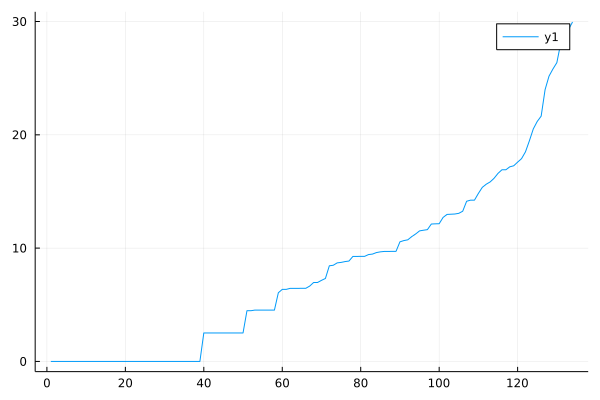

In [28]:
p1 = plot(sort(diffE_Vsamps,rev=false))

# Frequency count: